In [57]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [58]:
df = pd.read_csv('./data/test_clientsayu.csv')
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['Longitude'], df['Latitude']), crs="EPSG:4326")
gdf

,IdAddress,Longitude,Latitude,nMonto_Liquidar,geometry
0,0,-103.388824,20.694038,NaN,POINT (-103.38882 20.69404)
1,1,-103.480000,20.462600,5228.60,POINT (-103.48 20.4626)
2,2,-103.439000,20.463200,8200.10,POINT (-103.439 20.4632)
3,3,-103.389000,20.416700,1873.14,POINT (-103.389 20.4167)
4,4,-102.783000,20.787400,22174.70,POINT (-102.783 20.7874)
...,...,...,...,...,...
164,164,-103.448000,20.473700,5892.04,POINT (-103.448 20.4737)
165,165,-103.237000,20.524000,7137.60,POINT (-103.237 20.524)
166,166,-103.443000,20.468700,20869.00,POINT (-103.443 20.4687)
167,167,-103.444000,20.473000,3166.56,POINT (-103.444 20.473)


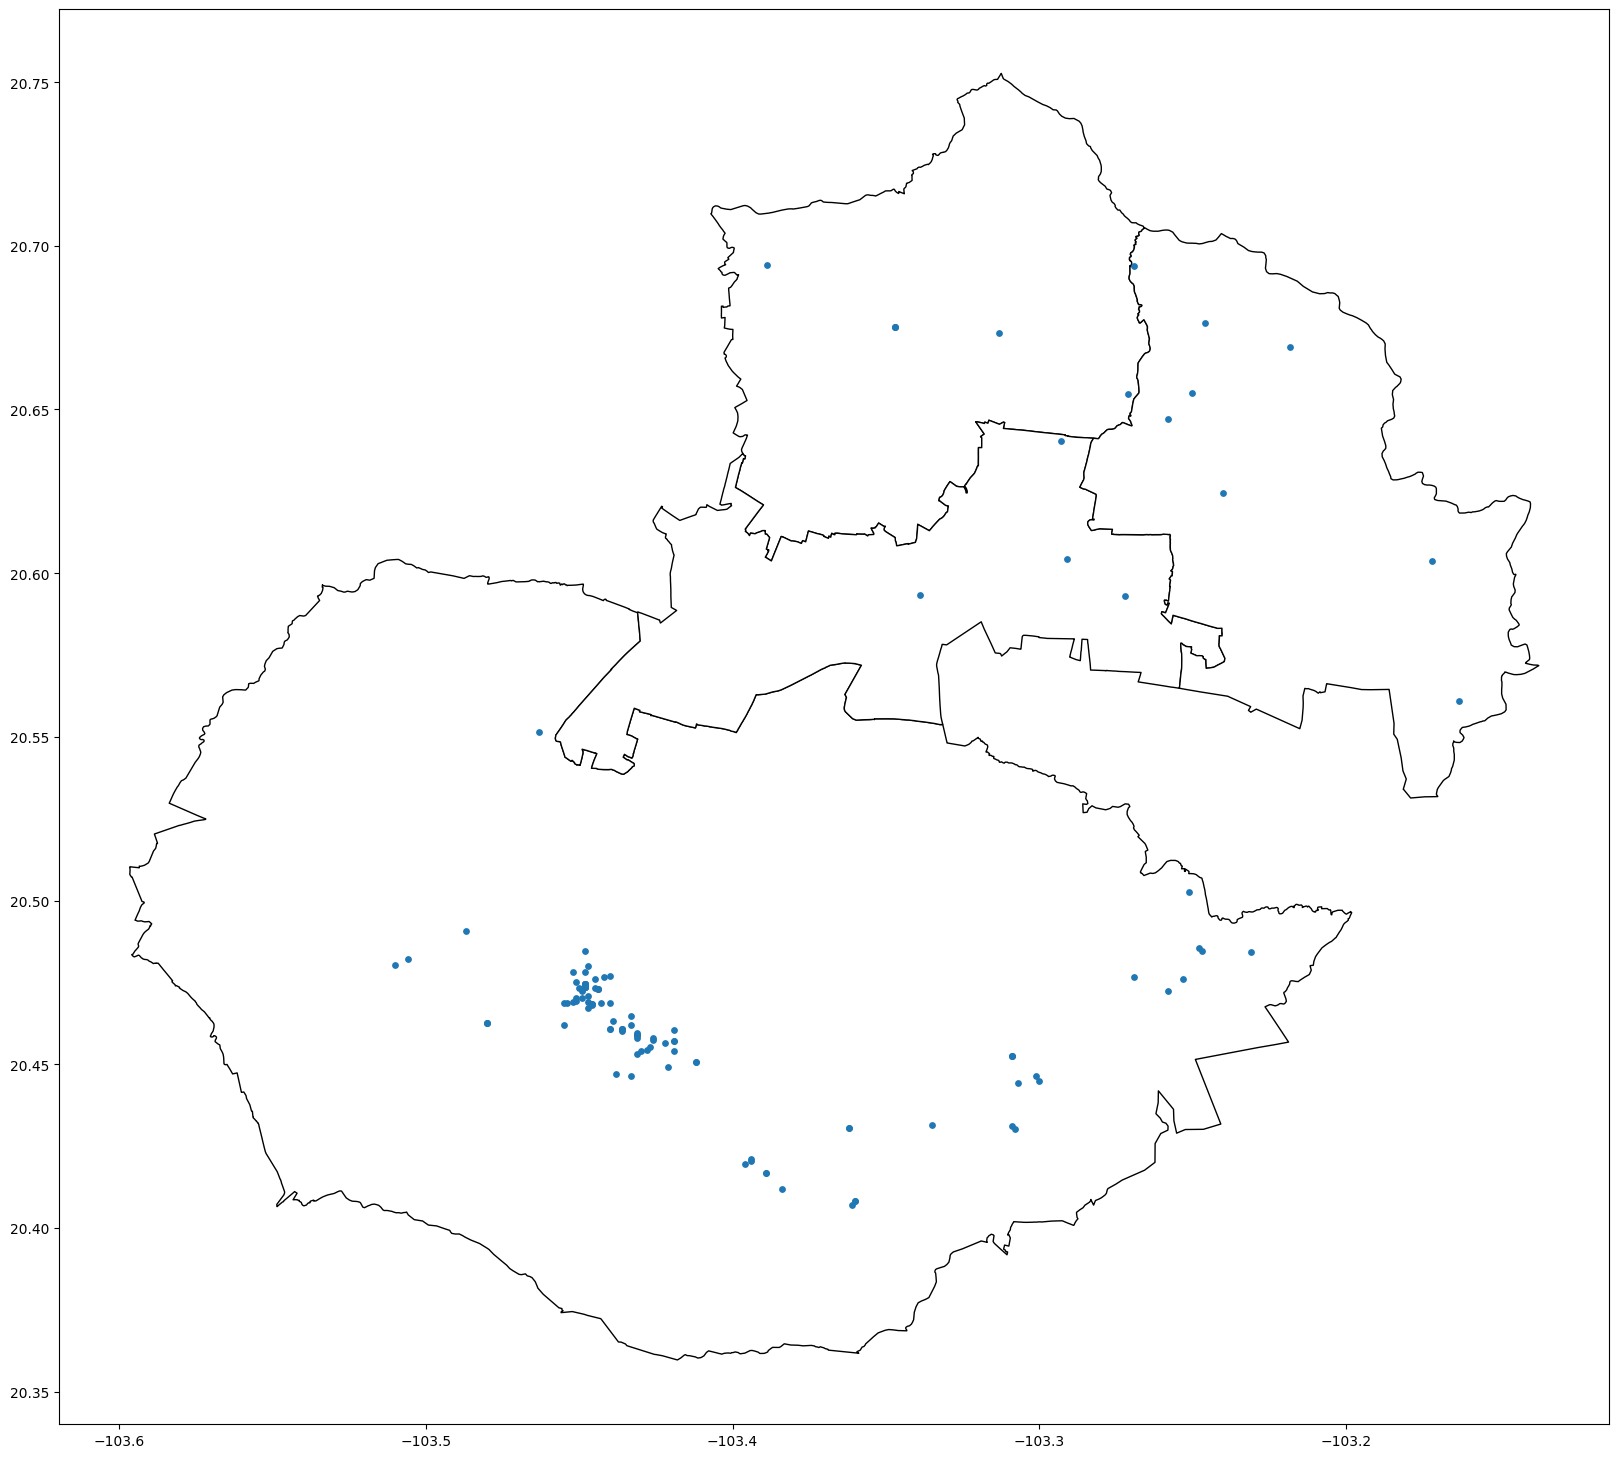

In [59]:
# Shapefile Mexico2
mexico2 = gpd.read_file('./shapes/muni_2012gw/Muni_2012gw.shp')

# Filter for the municipalities you're interested in
municipalities = ['039', '098', '097', '101']
#municipalities = ['039', '120', '098', '097', '101']

# Filter for exact CVE_ENT and CVE_MUN codes
zona_metropolitana = mexico2[(mexico2['CVE_MUN'].isin(municipalities)) & (mexico2['CVE_ENT'] == '14')]

# Limit coords to zona metropolitana
gdf_joined = gpd.sjoin(gdf, zona_metropolitana, how='inner', predicate='within').set_crs('EPSG:4326')
gdf = gdf_joined.copy()[gdf.columns] 

# Plotting
base = zona_metropolitana.plot(color='white', edgecolor='black', figsize=(20,20))
gdf.plot(ax=base, markersize=15, legend=True)
plt.show()


In [60]:
from sklearn.cluster import KMeans

C:\Users\alvar\AppData\Local\Temp\ipykernel_8764\3834127183.py:12: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  gdf_centers['geometry'] = gpd.points_from_xy(gdf_centers['Longitude'], gdf_centers['Latitude'])


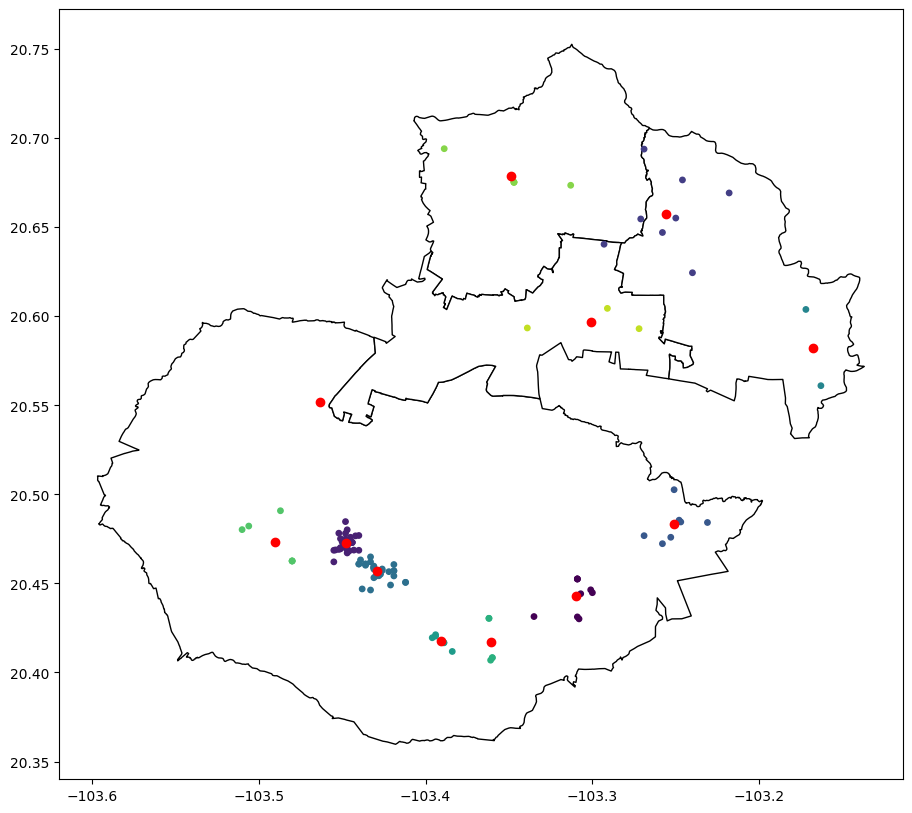

In [61]:
# Clustering con sklearn
coordinates = gdf[['Latitude', 'Longitude']]
kmeans = KMeans(n_clusters=12)
kmeans.fit(coordinates)

# Extract cluster labels and centers
gdf['kmeans_cluster'] = kmeans.labels_
cluster_centers = kmeans.cluster_centers_

# Create a GeoDataFrame for the cluster centers
gdf_centers = gpd.GeoDataFrame(cluster_centers, columns=['Latitude', 'Longitude'])
gdf_centers['geometry'] = gpd.points_from_xy(gdf_centers['Longitude'], gdf_centers['Latitude'])
gdf_centers = gdf_centers.set_crs("EPSG:4326")

# Plotting
base2 = zona_metropolitana.plot(color='white', edgecolor='black', figsize=(15,10))

gdf.plot(ax=base2, column='kmeans_cluster', markersize=15)
gdf_centers.plot(ax=base2, color='red')

plt.show()


In [62]:
cluster_list = []
for cluster in sorted(gdf['kmeans_cluster'].unique()):
    cluster_list.append(gdf[gdf['kmeans_cluster'] == cluster])

In [71]:
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp


def create_data_model():
    """Stores the data for the problem."""
    data = {}
    data["distance_matrix"] = pd.read_csv('./data/test_clientsmatayu.csv', index_col=None).values.tolist()
    data["num_vehicles"] = 1
    data["depot"] = 0
    return data


def print_solution(data, manager, routing, solution):
    """Prints solution on console."""
    print(f"Objective: {solution.ObjectiveValue()}")
    max_route_distance = 0
    for vehicle_id in range(data["num_vehicles"]):
        index = routing.Start(vehicle_id)
        plan_output = f"Route for vehicle {vehicle_id}:\n"
        route_distance = 0
        while not routing.IsEnd(index):
            plan_output += f" {manager.IndexToNode(index)} -> "
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id
            )
        plan_output += f"{manager.IndexToNode(index)}\n"
        plan_output += f"Distance of the route: {route_distance}m\n"
        print(plan_output)
        max_route_distance = max(route_distance, max_route_distance)
    print(f"Maximum of the route distances: {max_route_distance}m")



def main():
    """Entry point of the program."""
    # Instantiate the data problem.
    data = create_data_model()

    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(
        len(data["distance_matrix"]), data["num_vehicles"], data["depot"]
    )

    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)

    # Create and register a transit callback.
    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data["distance_matrix"][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    )

    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)

    # Print solution on console.
    if solution:
        print_solution(data, manager, routing, solution)
    else:
        print("No solution found !")


if __name__ == "__main__":
    main()

Objective: 527861
Route for vehicle 0:
 0 ->  22 ->  95 ->  64 ->  48 ->  59 ->  17 ->  1 ->  80 ->  23 ->  102 ->  54 ->  90 ->  82 ->  27 ->  28 ->  12 ->  164 ->  137 ->  133 ->  118 ->  104 ->  79 ->  69 ->  130 ->  129 ->  126 ->  85 ->  50 ->  20 ->  62 ->  122 ->  127 ->  92 ->  37 ->  131 ->  116 ->  155 ->  117 ->  89 ->  167 ->  52 ->  51 ->  98 ->  144 ->  114 ->  84 ->  29 ->  30 ->  166 ->  61 ->  2 ->  125 ->  124 ->  115 ->  18 ->  19 ->  154 ->  143 ->  134 ->  160 ->  149 ->  147 ->  141 ->  60 ->  152 ->  103 ->  88 ->  70 ->  96 ->  56 ->  113 ->  161 ->  151 ->  150 ->  83 ->  99 ->  139 ->  8 ->  146 ->  123 ->  148 ->  168 ->  145 ->  120 ->  3 ->  163 ->  158 ->  107 ->  91 ->  112 ->  106 ->  76 ->  49 ->  63 ->  101 ->  53 ->  57 ->  110 ->  140 ->  105 ->  47 ->  74 ->  38 ->  156 ->  44 ->  142 ->  40 ->  71 ->  68 ->  86 ->  16 ->  159 ->  75 ->  97 ->  165 ->  55 ->  45 ->  46 ->  93 ->  21 ->  108 ->  11 ->  14 ->  121 ->  162 ->  132 ->  39 ->  32 ->  35 